In [5]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from pathlib import Path
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import os


In [6]:
# dir_path = Path(r'N:\Research\DIR for QoL Study\H&N PRO Spreadsheets')
# dir_path = Path(r'C:\Users\The Supreme Being\Documents\Research\Head and Neck QoL Project')
dir_path = Path(r'C:\Users\adamyarschenko\OneDrive - University of Calgary\Head and Neck QoL Project')
# dir_path = Path(r'C:\Users\The Supreme Being\OneDrive - University of Calgary\Head and Neck QoL Project')
file_location = Path(dir_path, r'Anonymized Data (Complete - 66-70 Gy).csv')


In [7]:
#df = pd.read_excel(file_location, index_col=0)
df = pd.read_csv(file_location)

In [8]:
df.head(5)

,QoLID,MonthsSinceTx,Age,Gender,CancerSite,Tstage,Nstage,ChemoAgent,ECOG,CharlsonScore,...,XQ7,XQ8,XQ_EAT_SUM,XQ_EAT_AVE(,XQ_NOTEAT_SUM,XQ_NOTEAT_AVE,XQ_TOTAL_SUM,XQ_TOTAL_AVE,SubmandIpsInitDmean,SubmandContInitDmean
0,1,3,48,Gender_M,Nasopharynx,T0_T2,N2,Cisplatin,0,2,...,8.0,7.0,19.0,4.75,12.0,3.00,31.0,3.875,NaN,NaN
1,2,8,67,Gender_M,Oropharynx,T3_T4,N3,Cisplatin,1,4,...,0.0,2.0,0.0,0.00,2.0,0.50,2.0,0.250,NaN,NaN
2,3,14,47,Gender_M,Oropharynx,T0_T2,N2,Cisplatin,0,2,...,8.0,4.0,13.0,3.25,8.0,2.00,21.0,2.625,NaN,NaN
3,4,12,34,Gender_F,Nasal Cavity,T3_T4,N0,Cisplatin,0,2,...,3.0,4.0,4.0,1.00,7.0,1.75,11.0,1.375,60.7293,39.5566
4,6,20,61,Gender_M,Oropharynx,T0_T2,N2,Cisplatin,0,5,...,7.0,0.0,18.0,4.50,3.0,0.75,21.0,2.625,NaN,14.0800


MDASI Symptom burder: none (item rating of 0); mild (1 to 4); moderate (5 to 6); or severe (7 to 10) 
Summary scores for each of the core, head and neck, and interference subgroups are defined by the maximum rating of any item within that subgroup. Subgroup symptom burden is interpreted as: none (all items rated 0); mild (all items rated <5 with at least one item rated ≥1); moderate (all items rated <7 with at least one item rate ≥5); severe (at least one item rated ≥7).

MDADI has Emptional (E), Physical (P), and Functional (F). Physical swallowing ability (8 items), functional impact of swallowing dysfunction (5 items), emotional impact (6 items), and the general influence of swallowing ability on daily life (1 item)
Rated on 5 point scale; strongly agree to strongly disagree
Values were concerted to 1-5, summed, then normalized to 100. With this conversion, MDADI scores are interpreted as: minimal (summary score of 0 to 19), mild (20 to 39), moderate (40 to 59), severe (60 to 79), and profound (80 to 100) 

XQ rated 8 questions on eating (4), not eating (4). Sarah totaled then normalized out of 100 in her paper.

In [9]:
df['MDADI_TOTAL_SUM'].describe()

count    154.000000
mean      44.311688
std       14.657983
min       20.000000
25%       32.250000
50%       43.000000
75%       54.000000
max       80.000000
Name: MDADI_TOTAL_SUM, dtype: float64

### Read the questions into their own dataframes

In [10]:
df_MDASI = df.loc[:,'MDASI1':'MDASI_TOTAL_AVE']
df_MDADI = df.loc[:, 'MDADI1':'MDADI_TOTAL_AVE']
df_XQ = df.loc[:, 'XQ1':'XQ_TOTAL_AVE']

In [11]:
df_MDASI.head()

,MDASI1,MDASI2,MDASI3,MDASI4,MDASI5,MDASI6,MDASI7,MDASI8,MDASI9,MDASI10,...,MDASI27,MDASI28,MDASI_CORE_SUM,MDASI_CORE_AVE,MDASI_HN_SUM,MDASI_HN_AVE,MDASI_INT_SUM,MDASI_INT_AVE,MDASI_TOTAL_SUM,MDASI_TOTAL_AVE
0,0,1,0,0,0,0,0,0.0,0,4,...,0,1,5,0.384615,10,1.111111,2,0.333333,17,0.607143
1,0,7,0,0,0,5,2,5.0,5,0,...,7,0,28,2.153846,5,0.555556,29,4.833333,62,2.214286
2,0,0,0,0,0,0,0,0.0,0,4,...,0,0,4,0.307692,12,1.333333,0,0.000000,16,0.571429
3,0,2,0,0,0,0,2,0.0,0,2,...,2,1,7,0.538462,1,0.111111,5,0.833333,13,0.464286
4,0,0,0,0,0,0,0,0.0,0,0,...,0,0,0,0.000000,10,1.111111,0,0.000000,10,0.357143


### Read in data exported from RStudio to .csv. MDADI and XQ have been normalized to 100. MDASI has not been normalized. Scoring for the MDASI categories such as MDASI_CORE are done by taking the highest value from the corresponding group of questions. This is different than the summation performed in df_MDASI 

In [12]:
MDADI_norm = pd.read_csv(Path(dir_path, r'MDADI_Combined.csv'))
MDASI_combined = pd.read_csv(Path(dir_path, r'MDASI_Combined.csv'))
XQ_sum = df_XQ.loc[:,['XQ_EAT_SUM', 'XQ_NOTEAT_SUM', 'XQ_TOTAL_SUM']]
XQ_norm = XQ_sum[['XQ_EAT_SUM','XQ_NOTEAT_SUM']]*100/40 
XQ_norm = pd.concat([XQ_norm, XQ_sum['XQ_TOTAL_SUM']*100/80], axis=1)

In [13]:
# MDASI_combined.head()

In [14]:
df_MDASI.head()

,MDASI1,MDASI2,MDASI3,MDASI4,MDASI5,MDASI6,MDASI7,MDASI8,MDASI9,MDASI10,...,MDASI27,MDASI28,MDASI_CORE_SUM,MDASI_CORE_AVE,MDASI_HN_SUM,MDASI_HN_AVE,MDASI_INT_SUM,MDASI_INT_AVE,MDASI_TOTAL_SUM,MDASI_TOTAL_AVE
0,0,1,0,0,0,0,0,0.0,0,4,...,0,1,5,0.384615,10,1.111111,2,0.333333,17,0.607143
1,0,7,0,0,0,5,2,5.0,5,0,...,7,0,28,2.153846,5,0.555556,29,4.833333,62,2.214286
2,0,0,0,0,0,0,0,0.0,0,4,...,0,0,4,0.307692,12,1.333333,0,0.000000,16,0.571429
3,0,2,0,0,0,0,2,0.0,0,2,...,2,1,7,0.538462,1,0.111111,5,0.833333,13,0.464286
4,0,0,0,0,0,0,0,0.0,0,0,...,0,0,0,0.000000,10,1.111111,0,0.000000,10,0.357143


In [15]:
#Remove patients who have not completed all questions
df_filtered = df.dropna(subset=['MDADI16', 'XQ1'])

In [16]:
#Check to see if there are any other patients who have not completed all questions.
df_filtered.loc[:, 'MDADI16':'MDADI19'].isnull().describe()


,MDADI16,MDADI17,MDADI18,MDADI19
count,151,151,151,151
unique,1,1,1,1
top,False,False,False,False
freq,151,151,151,151


In [17]:
df_filtered['MDADI16'].value_counts()

1.0    48
2.0    42
4.0    34
5.0    15
3.0    12
Name: MDADI16, dtype: int64

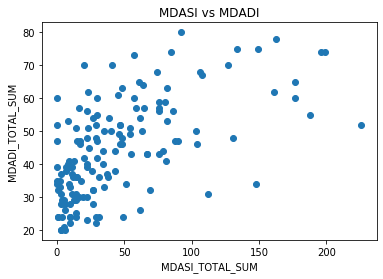

In [18]:
x = df_filtered['MDASI_TOTAL_SUM']
y = df_filtered['MDADI_TOTAL_SUM']
z = df_filtered['XQ_TOTAL_SUM']
plt.scatter(x,y)
plt.xlabel('MDASI_TOTAL_SUM')
plt.ylabel('MDADI_TOTAL_SUM')
plt.title('MDASI vs MDADI')

plt.show()

In [19]:
df_filtered['MDASI_TOTAL_SUM'].describe()

count    151.000000
mean      45.536424
std       47.413609
min        0.000000
25%       11.000000
50%       29.000000
75%       63.500000
max      226.000000
Name: MDASI_TOTAL_SUM, dtype: float64

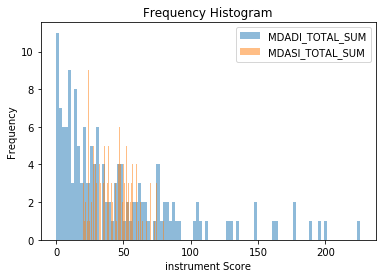

In [20]:
kwargs = dict(alpha=0.5, bins=100)
plt.hist(x, **kwargs, label='MDADI_TOTAL_SUM')
plt.hist(y, **kwargs, label='MDASI_TOTAL_SUM')
plt.gca().set(title='Frequency Histogram', xlabel = 'instrument Score', ylabel='Frequency');
plt.legend()

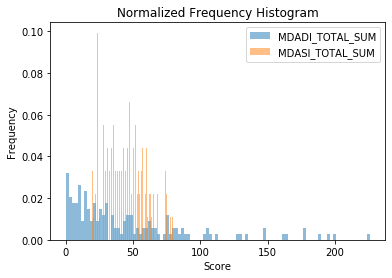

In [21]:
kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True)
plt.hist(x, **kwargs, label='MDADI_TOTAL_SUM')
plt.hist(y, **kwargs, label='MDASI_TOTAL_SUM')
plt.gca().set(title='Normalized Frequency Histogram', xlabel = 'Score', ylabel='Frequency');
plt.legend()

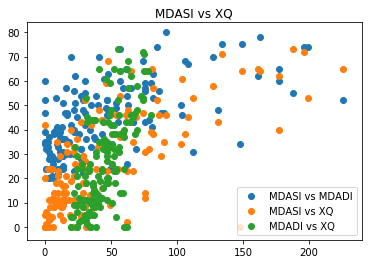

In [22]:
# plt.xlabel('MDASI_TOTAL_SUM')
# plt.ylabel('XQ_TOTAL_SUM')
plt.title('MDASI vs XQ')
plt.scatter(x,y, label='MDASI vs MDADI')
plt.scatter(x,z, label= 'MDASI vs XQ')
plt.scatter(y,z, label='MDADI vs XQ')
plt.legend()
plt.show()


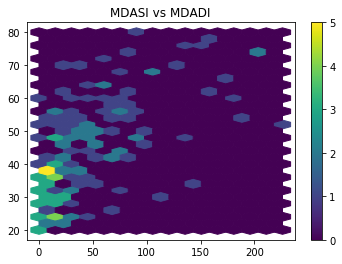

In [23]:
# Make the plot
plt.hexbin(x, y, gridsize=(15,15) )
plt.colorbar()
plt.title('MDASI vs MDADI')
plt.show()

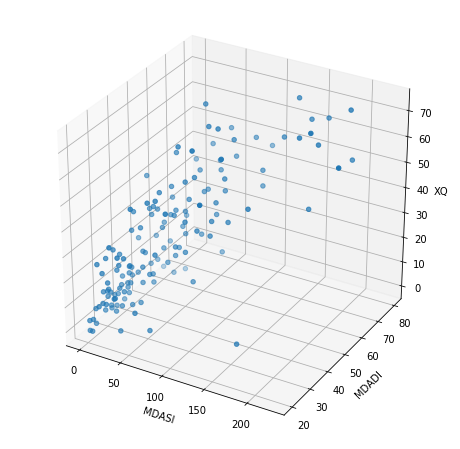

In [24]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(x,y,z)
ax.set_xlabel('MDASI')
ax.set_ylabel('MDADI')
ax.set_zlabel('XQ')
plt.show()

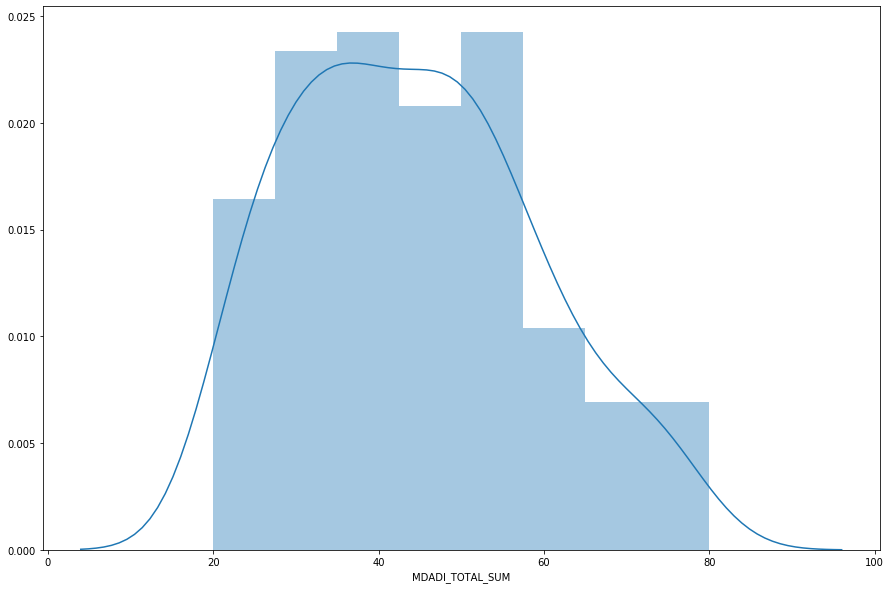

In [25]:
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(df['MDADI_TOTAL_SUM'])

In [26]:
X = df_filtered['MDADI_TOTAL_SUM'].values.reshape(-1,1)
y = df_filtered['MDASI_TOTAL_SUM'].values.reshape(-1,1)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [28]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [29]:
#To retrieve the intercept:
print(regressor.intercept_)#For retrieving the slope:
print(regressor.coef_)

[-42.94023942]
[[2.08296421]]


In [30]:
y_pred = regressor.predict(X_test)

In [31]:
df_ml = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})


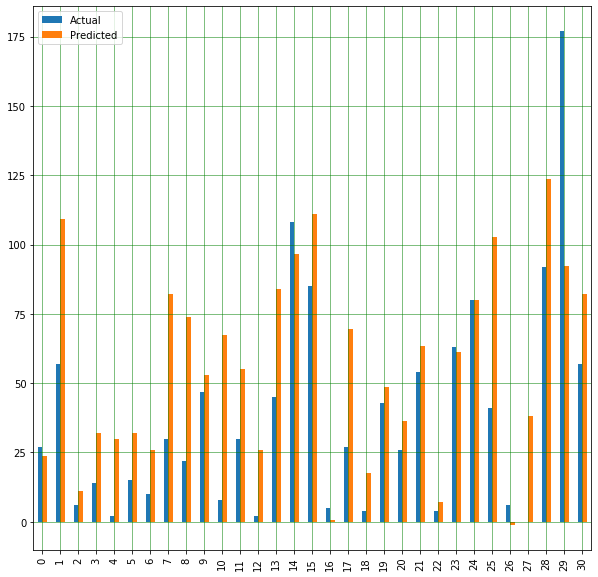

In [51]:
df1 = df_ml.head(50)
df1.plot(kind='bar',figsize=(10,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

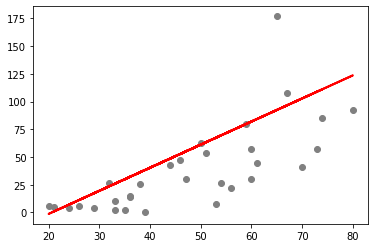

In [52]:
plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

In [53]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 24.93670083567262
Mean Squared Error: 1072.8987264913014
Root Mean Squared Error: 32.755132826647205


In [54]:
survey_df = df_filtered.loc[:, 'MDASI1':]

In [55]:
survey_df.columns


Index(['MDASI1', 'MDASI2', 'MDASI3', 'MDASI4', 'MDASI5', 'MDASI6', 'MDASI7',
       'MDASI8', 'MDASI9', 'MDASI10', 'MDASI11', 'MDASI12', 'MDASI13',
       'MDASI14', 'MDASI15', 'MDASI16', 'MDASI17', 'MDASI18', 'MDASI19',
       'MDASI20', 'MDASI21', 'MDASI22', 'MDASI23', 'MDASI24', 'MDASI25',
       'MDASI26', 'MDASI27', 'MDASI28', 'MDASI_CORE_SUM', 'MDASI_CORE_AVE',
       'MDASI_HN_SUM', 'MDASI_HN_AVE', 'MDASI_INT_SUM', 'MDASI_INT_AVE',
       'MDASI_TOTAL_SUM', 'MDASI_TOTAL_AVE', 'MDADI1', 'MDADI2', 'MDADI3',
       'MDADI4', 'MDADI5', 'MDADI6', 'MDADI7', 'MDADI8', 'MDADI9', 'MDADI10',
       'MDADI11', 'MDADI12', 'MDADI13', 'MDADI14', 'MDADI15', 'MDADI16',
       'MDADI17', 'MDADI18', 'MDADI19', 'MDADI20', 'MDADI_E_SUM',
       'MDADI_E_AVE', 'MDADI_F_SUM', 'MDADI_F_AVE', 'MDADI_P_SUM',
       'MDADI_P_AVE', 'MDADI_TOTAL_SUM', 'MDADI_TOTAL_AVE', 'XQ1', 'XQ2',
       'XQ3', 'XQ4', 'XQ5', 'XQ6', 'XQ7', 'XQ8', 'XQ_EAT_SUM', 'XQ_EAT_AVE(',
       'XQ_NOTEAT_SUM', 'XQ_NOTEAT_AVE', 'XQ_T

In [56]:
# category_sums = survey_df.loc[:, ['MDASI_CORE_SUM', 'MDASI_HN_SUM', 'MDASI_INT_SUM', 
#                                'MDASI_TOTAL_SUM', 'MDADI_E_SUM', 
#                                'MDADI_F_SUM', 'MDADI_P_SUM', 
#                                'MDADI_TOTAL_SUM', 'XQ_EAT_SUM', 'XQ_NOTEAT_SUM', 'XQ_TOTAL_SUM' ]]
category_sums = survey_df.loc[:, ['MDASI_CORE_SUM', 'MDASI_HN_SUM', 'MDASI_INT_SUM', 'MDADI_E_SUM', 
                               'MDADI_F_SUM', 'MDADI_P_SUM', 'XQ_EAT_SUM', 'XQ_NOTEAT_SUM']]

In [57]:
corr_table = category_sums.corr()
corr_table

,MDASI_CORE_SUM,MDASI_HN_SUM,MDASI_INT_SUM,MDADI_E_SUM,MDADI_F_SUM,MDADI_P_SUM,XQ_EAT_SUM,XQ_NOTEAT_SUM
MDASI_CORE_SUM,1.000000,0.837973,0.725089,0.441621,0.490298,0.482829,0.557555,0.650915
MDASI_HN_SUM,0.837973,1.000000,0.663788,0.497448,0.520270,0.555399,0.629513,0.655968
MDASI_INT_SUM,0.725089,0.663788,1.000000,0.415369,0.503165,0.465063,0.592773,0.658435
MDADI_E_SUM,0.441621,0.497448,0.415369,1.000000,0.780247,0.721535,0.509479,0.529215
MDADI_F_SUM,0.490298,0.520270,0.503165,0.780247,1.000000,0.686520,0.556540,0.602275
MDADI_P_SUM,0.482829,0.555399,0.465063,0.721535,0.686520,1.000000,0.627319,0.602708
XQ_EAT_SUM,0.557555,0.629513,0.592773,0.509479,0.556540,0.627319,1.000000,0.848011
XQ_NOTEAT_SUM,0.650915,0.655968,0.658435,0.529215,0.602275,0.602708,0.848011,1.000000


In [58]:
MDASI = survey_df.loc[:, "MDASI1":"MDASI28"]
MDASI = MDASI.dropna()
# MDASI.isna().sum()

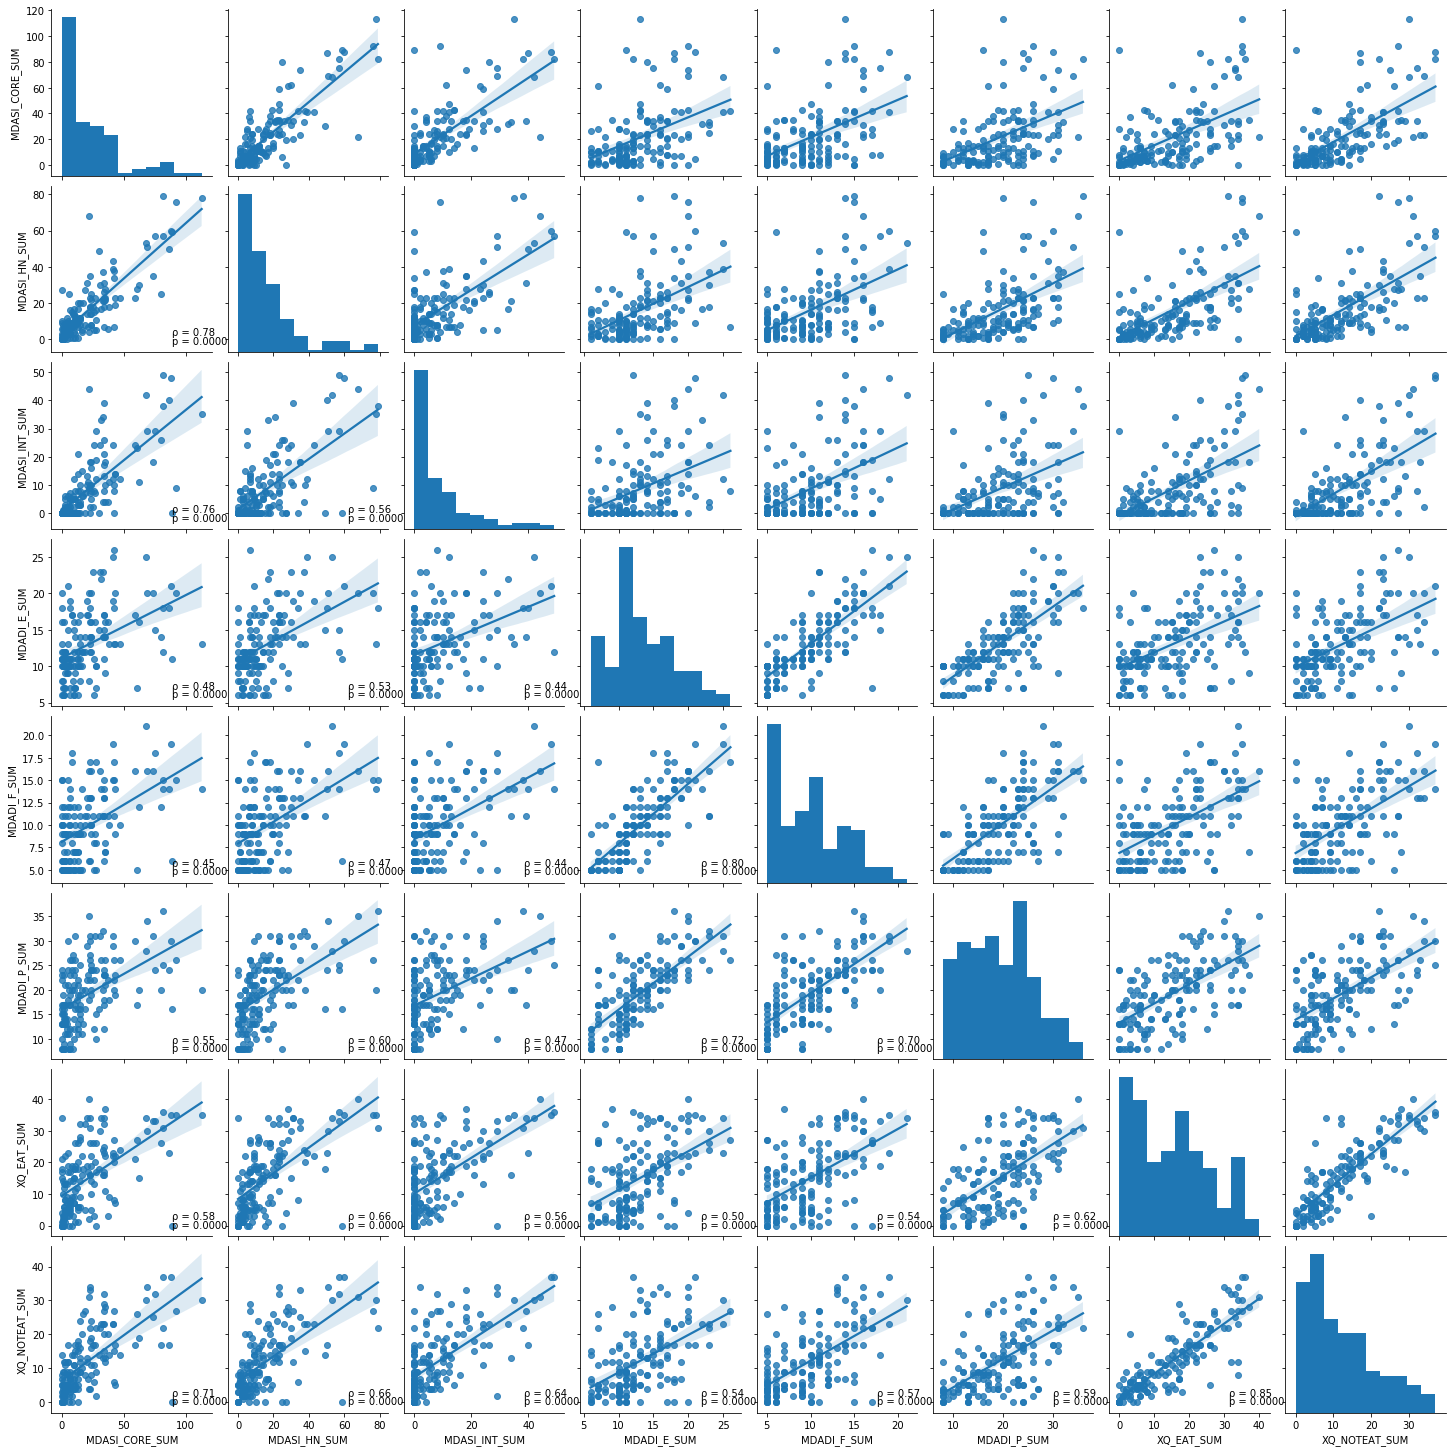

In [96]:
from scipy.stats import pearsonr, spearmanr #person linear, spearman non-linear. Spearman used in Tyler paper. 
g = sns.pairplot(category_sums, kind='reg', palette="Set2")
def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the bottom right hand corner of a plot."""
    r, p = spearmanr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.75, .1), xycoords=ax.transAxes)
    ax.annotate(f'p = {p:.6f}', xy=(.75, .05), xycoords=ax.transAxes)
#     ax.annotate('p < 0.001', xy=(.1, .8), xycoords=ax.transAxes)
#     print('r=', r, 'p=',p)
g.map_lower(corrfunc)
plt.show()

### Shaded area is 95% confidence interval

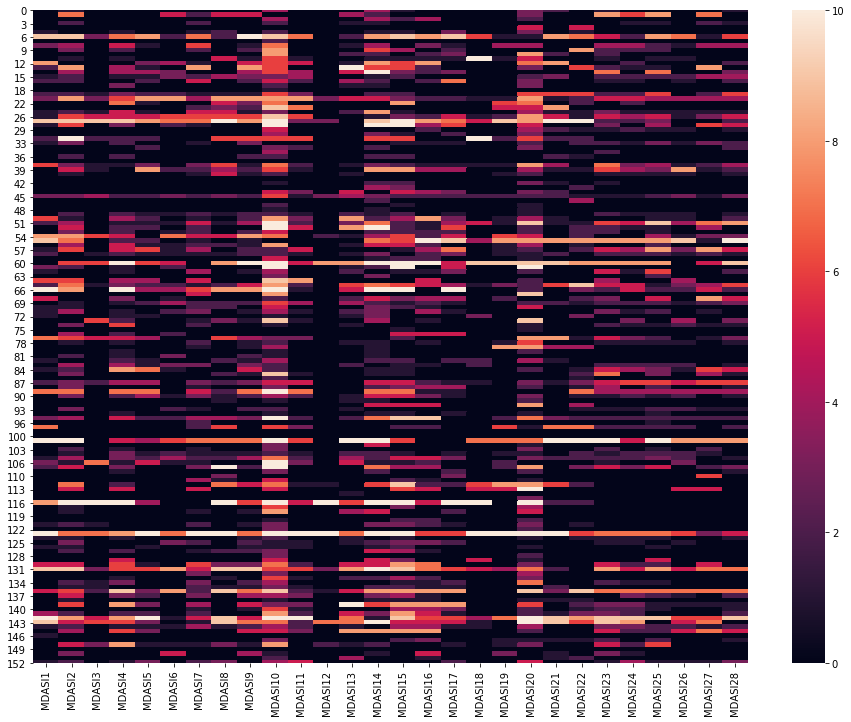

In [91]:
fig = plt.figure(figsize=(16,12))
sns.heatmap(MDASI)

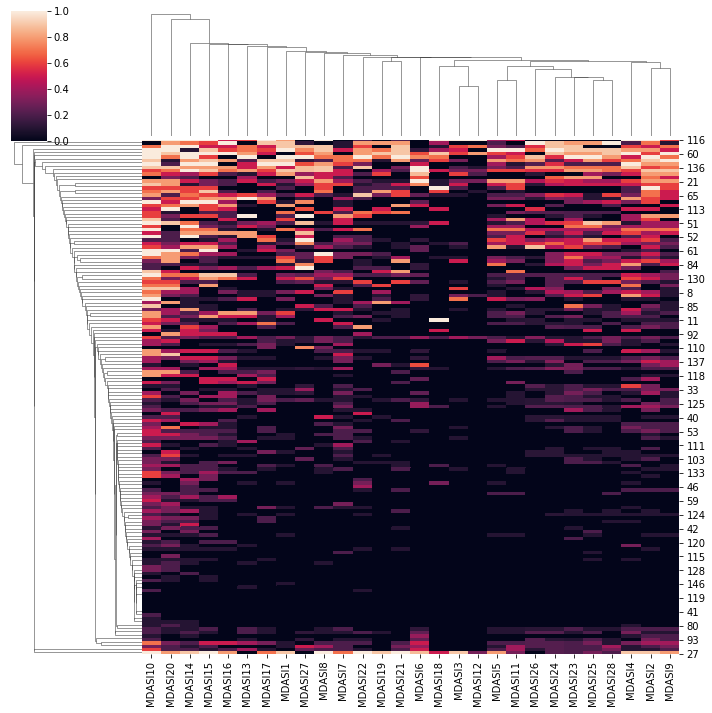

In [92]:
# fig = plt.figure(figsize=(16,12))
sns.clustermap(MDASI, metric="euclidean", standard_scale=1, method="single")

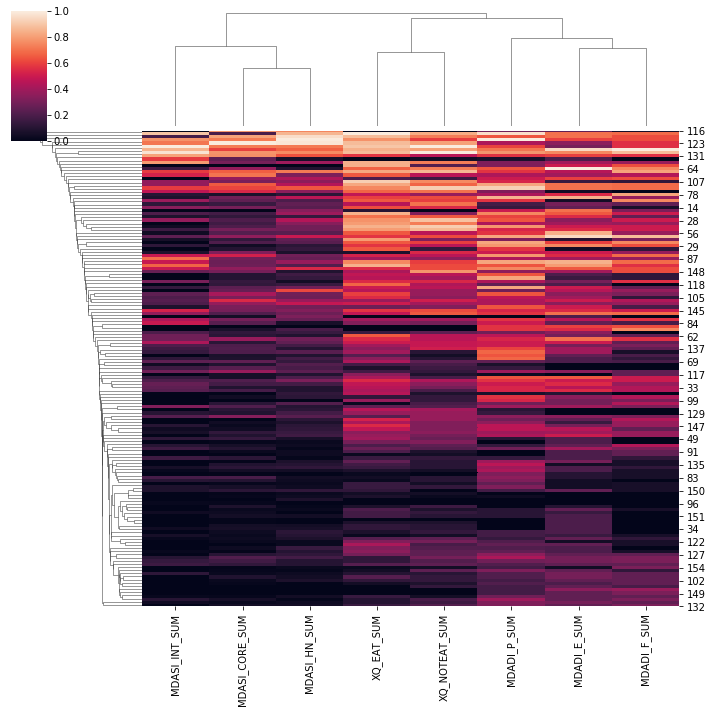

In [97]:
# fig = plt.figure(figsize=(16,12))
sns.clustermap(category_sums, metric="euclidean", standard_scale=1, method="single")

### Mann-Whitney tests. How similar are the populations?

In [98]:
# df_MDASI
# df_MDADI
# df_XQ 

In [59]:
df_MDASI.columns

Index(['MDASI1', 'MDASI2', 'MDASI3', 'MDASI4', 'MDASI5', 'MDASI6', 'MDASI7',
       'MDASI8', 'MDASI9', 'MDASI10', 'MDASI11', 'MDASI12', 'MDASI13',
       'MDASI14', 'MDASI15', 'MDASI16', 'MDASI17', 'MDASI18', 'MDASI19',
       'MDASI20', 'MDASI21', 'MDASI22', 'MDASI23', 'MDASI24', 'MDASI25',
       'MDASI26', 'MDASI27', 'MDASI28', 'MDASI_CORE_SUM', 'MDASI_CORE_AVE',
       'MDASI_HN_SUM', 'MDASI_HN_AVE', 'MDASI_INT_SUM', 'MDASI_INT_AVE',
       'MDASI_TOTAL_SUM', 'MDASI_TOTAL_AVE'],
      dtype='object')

In [104]:
stat, p = mannwhitneyu(df_MDASI['MDASI_TOTAL_SUM'], df_MDADI['MDADI_TOTAL_SUM'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=9418.000, p=0.001
Different distribution (reject H0)


In [105]:
stat, p = mannwhitneyu(df_MDASI['MDASI_TOTAL_SUM'], df_XQ['XQ_TOTAL_SUM'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=10139.500, p=0.009
Different distribution (reject H0)


In [106]:
stat, p = mannwhitneyu(df_MDASI['MDASI_TOTAL_SUM'], df_XQ['XQ_TOTAL_SUM'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=10139.500, p=0.009
Different distribution (reject H0)


### Perform Mann-Whitney U test to identify if the samples are drawn from the same distribution

In [119]:
df = pd.DataFrame(columns=[category_sums.columns])
p_values = np.zeros((len(category_sums.columns), len(category_sums.columns)))
for i in range(len(category_sums.columns)):
    category_sums.iloc[:, i]
    for j in range(0, len(category_sums.columns)):
        stat, p = mannwhitneyu(category_sums.iloc[:, i], category_sums.iloc[:, j])
        p_values[i][j] = p
        print(category_sums.columns[i], 'vs', category_sums.columns[j])
        alpha = 0.05
        if p > alpha:
            print('Same distribution (fail to reject H0) \n')
        else:
            print('Different distribution (reject H0)\n')


MDASI_CORE_SUM vs MDASI_CORE_SUM
Same distribution (fail to reject H0) 

MDASI_CORE_SUM vs MDASI_HN_SUM
Same distribution (fail to reject H0) 

MDASI_CORE_SUM vs MDASI_INT_SUM
Different distribution (reject H0)

MDASI_CORE_SUM vs MDADI_E_SUM
Same distribution (fail to reject H0) 

MDASI_CORE_SUM vs MDADI_F_SUM
Different distribution (reject H0)

MDASI_CORE_SUM vs MDADI_P_SUM
Different distribution (reject H0)

MDASI_CORE_SUM vs XQ_EAT_SUM
Same distribution (fail to reject H0) 

MDASI_CORE_SUM vs XQ_NOTEAT_SUM
Different distribution (reject H0)

MDASI_HN_SUM vs MDASI_CORE_SUM
Same distribution (fail to reject H0) 

MDASI_HN_SUM vs MDASI_HN_SUM
Same distribution (fail to reject H0) 

MDASI_HN_SUM vs MDASI_INT_SUM
Different distribution (reject H0)

MDASI_HN_SUM vs MDADI_E_SUM
Different distribution (reject H0)

MDASI_HN_SUM vs MDADI_F_SUM
Same distribution (fail to reject H0) 

MDASI_HN_SUM vs MDADI_P_SUM
Different distribution (reject H0)

MDASI_HN_SUM vs XQ_EAT_SUM
Same distribution (f

In [120]:
p_table = pd.DataFrame(p_values, columns=[category_sums.columns], index=[category_sums.columns])

# def color_rejH0(val):
#     color = 'black' if val < 0.05 else 'black'
#     return 'color: %s' % color
# p_table.style.applymap(color_rejH0)
p_table.round(3)

,MDASI_CORE_SUM,MDASI_HN_SUM,MDASI_INT_SUM,MDADI_E_SUM,MDADI_F_SUM,MDADI_P_SUM,XQ_EAT_SUM,XQ_NOTEAT_SUM
MDASI_CORE_SUM,0.500,0.073,0.0,0.289,0.003,0.004,0.182,0.007
MDASI_HN_SUM,0.073,0.500,0.0,0.049,0.125,0.000,0.193,0.176
MDASI_INT_SUM,0.000,0.000,0.5,0.000,0.000,0.000,0.000,0.000
MDADI_E_SUM,0.289,0.049,0.0,0.500,0.000,0.000,0.236,0.004
MDADI_F_SUM,0.003,0.125,0.0,0.000,0.500,0.000,0.000,0.351
MDADI_P_SUM,0.004,0.000,0.0,0.000,0.000,0.500,0.000,0.000
XQ_EAT_SUM,0.182,0.193,0.0,0.236,0.000,0.000,0.500,0.015
XQ_NOTEAT_SUM,0.007,0.176,0.0,0.004,0.351,0.000,0.015,0.500
